## Machine Learning Project Framework

### 1. Problem Definition
Define the problem you are solving.
- **Classification**: Predicting categories (e.g., customer churn: Yes/No)
- **Regression**: Predicting continuous values (e.g., house prices)
- **Clustering**: Grouping similar items (e.g., customer segmentation)
- **Time Series Forecasting**: Predicting future values (e.g., stock prices)
- **Anomaly Detection**: Identifying outliers (e.g., fraud detection)

Define success metrics based on the type of problem:
- **Classification**: Accuracy, Precision, Recall, F1-score, AUC-ROC
- **Regression**: RMSE, MAE, R²
- **Clustering**: Silhouette score, Davies-Bouldin index
- **Time Series**: MAPE, RMSE
- **Anomaly Detection**: Precision, recall, F1-score

### 2. Data Collection & Understanding
- Gather data from internal databases, APIs, web scraping, or external datasets.
- Understand the dataset structure:
  - Identify feature types (numerical, categorical, text, etc.).
  - Determine the target variable (classification or regression output).
  - Assess dataset quality (missing values, duplicates, inconsistencies).

In [629]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [630]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [631]:
print(df.dtypes)
print(df.nunique())

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object
customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64


In [632]:
# converting columns to categorical
categorical = ['gender','country']

for col in categorical:
    df[col] = df[col].astype('category')

# dropping the customer_id column as it is just an identifier
df.drop('customer_id', axis=1, inplace=True)

In [633]:
# checking for inconsistencies in the categorical columns
print(df['country'].unique())
print(df['gender'].unique())

# checking for inconsistencies in the numerical columns
df.describe()

['France', 'Spain', 'Germany']
Categories (3, object): ['France', 'Germany', 'Spain']
['Female', 'Male']
Categories (2, object): ['Female', 'Male']


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [634]:
# check for missing values
print(df.isnull().sum())
print(df.isnull().mean()*100)

# check for duplicates
print("Duplicates:", df.duplicated().sum())

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64
credit_score        0.0
country             0.0
gender              0.0
age                 0.0
tenure              0.0
balance             0.0
products_number     0.0
credit_card         0.0
active_member       0.0
estimated_salary    0.0
churn               0.0
dtype: float64
Duplicates: 0


### 3. Exploratory Data Analysis (EDA)
- **Handle missing values**
- **Visualize distributions** (histograms, box plots, KDE plots)
- **Analyze correlations** (heatmaps, pair plots)
- **Detect outliers** (Z-score, IQR method)

#### Potential Solutions
| **Issue**              | **Check Method**       | **Action** |
|------------------------|-----------------------|------------|
| **Skewed Distributions** | KDE, Histograms | Apply log/sqrt transformation |
| **Outliers** | Box Plot, Histogram | Clip, cap, or remove |
| **Uniform Distribution** | Histogram | Drop if not useful |
| **Class Imbalance** | Count Plot | Resample (SMOTE) or group rare categories |
| **Typos in Categories** | Unique Values | Standardize (lower(), strip()) |
| **Irrelevant Features** | Correlation with Target | Drop if no impact |

In [635]:
# no missing values or duplicates found

In [636]:
class_counts = df['churn'].value_counts()
class_ratio = (class_counts / class_counts.sum()) * 100

ratio_df = pd.DataFrame({'count': class_counts, 'ratio': class_ratio})
print(ratio_df)

       count  ratio
churn              
0       7963  79.63
1       2037  20.37


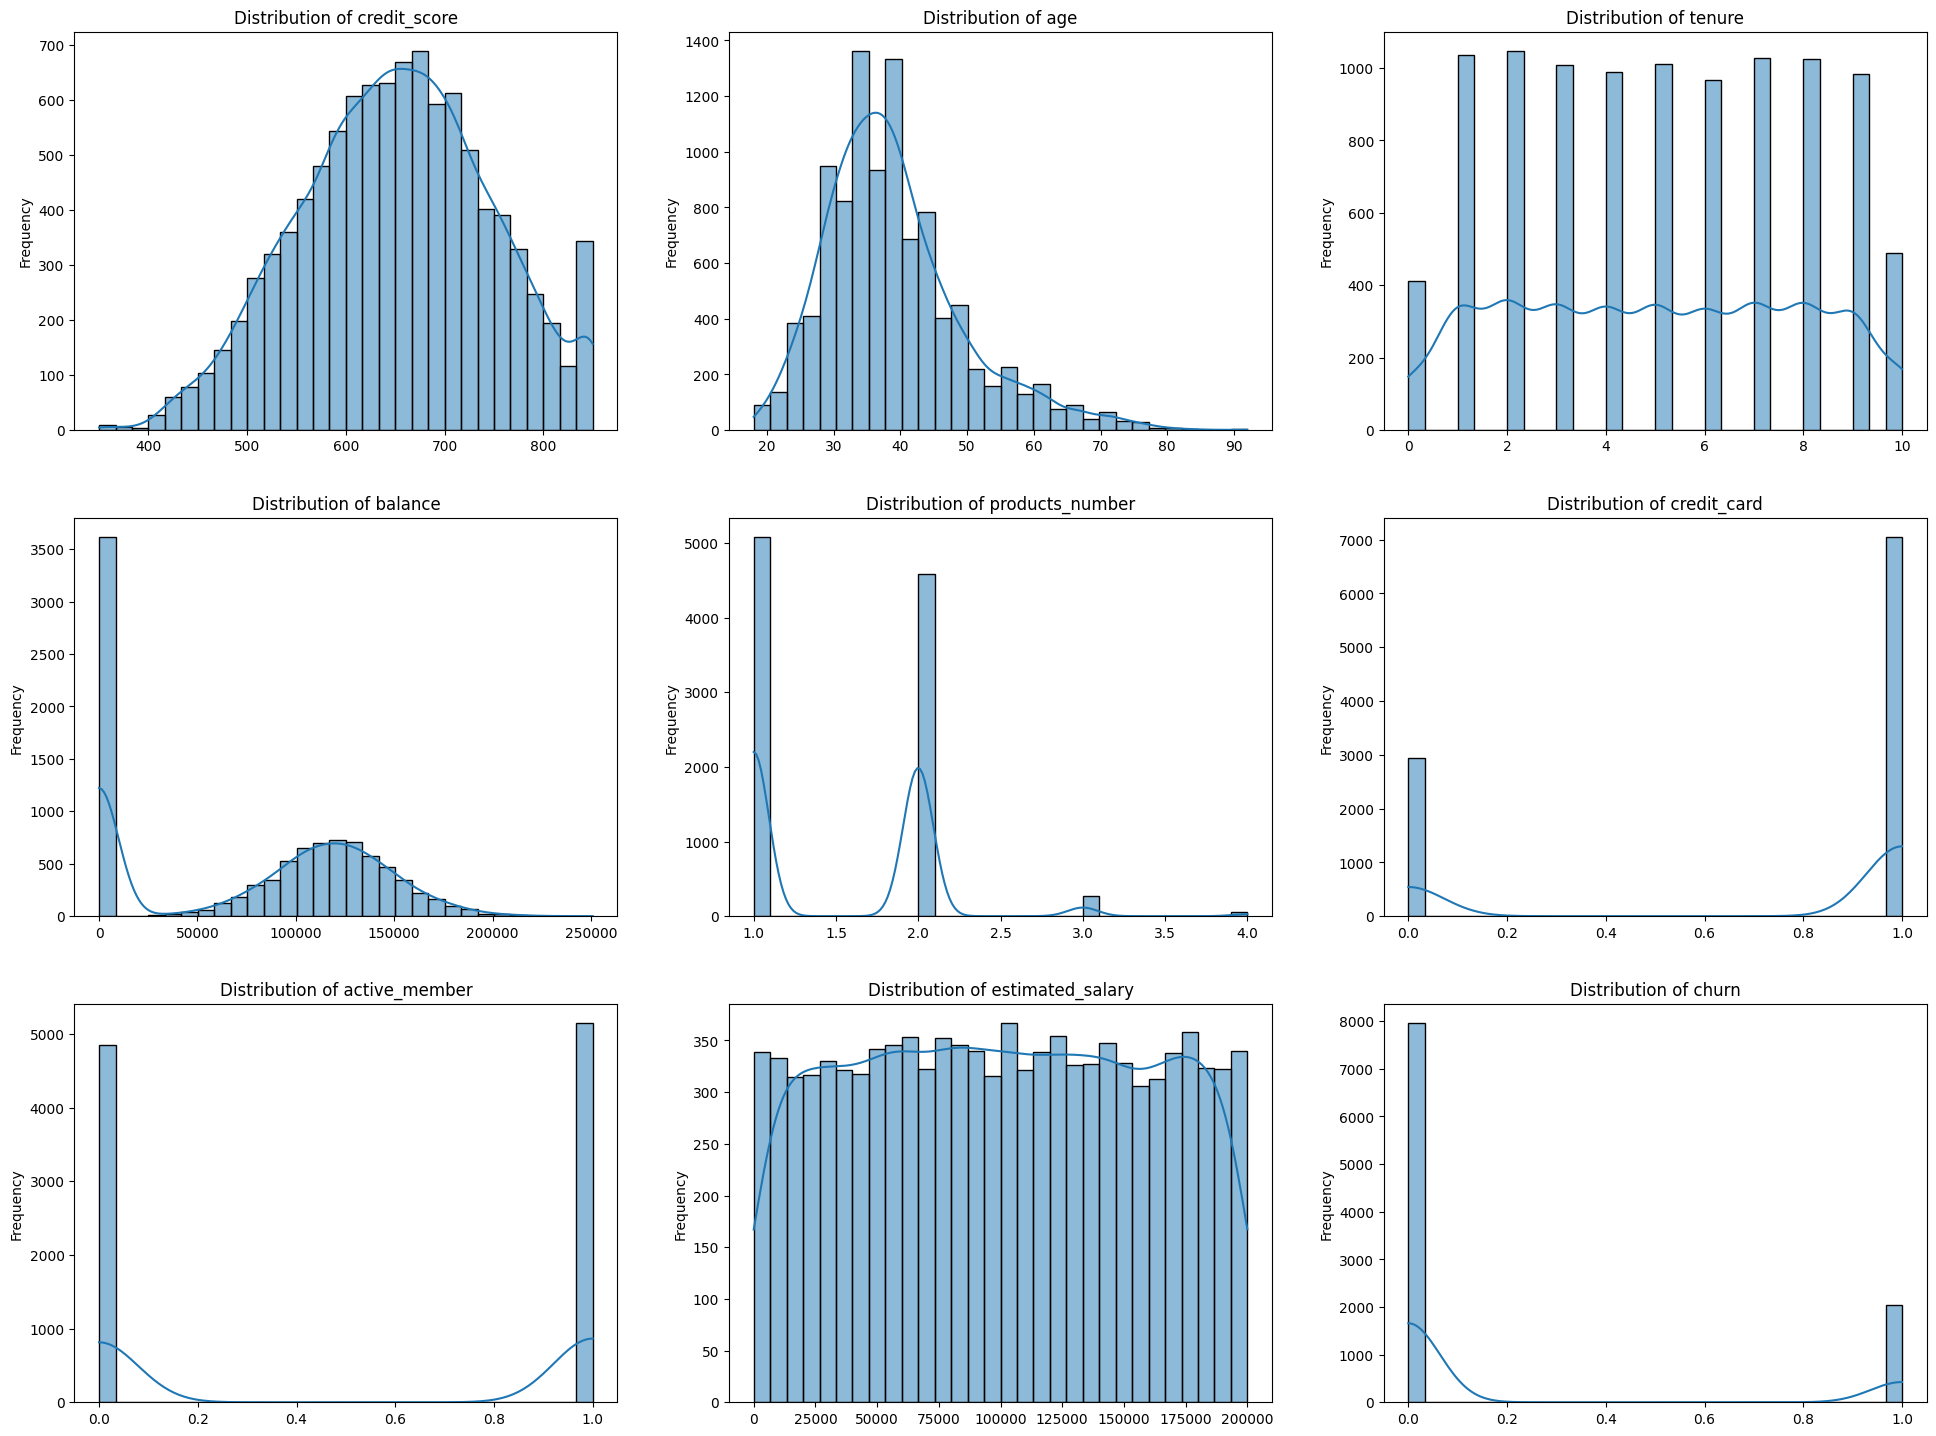

In [637]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Define grid size (3 plots per row)
num_cols = 3  
num_rows = math.ceil(len(numerical_cols) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))  # Increased row height
axes = axes.flatten()  # Flatten in case we have extra subplots

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel("")  # Optional: Remove x-axis label for cleaner look
    axes[i].set_ylabel("Frequency")  # Keep y-axis label for clarity

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)  # Adjust spacing between plots
plt.show()


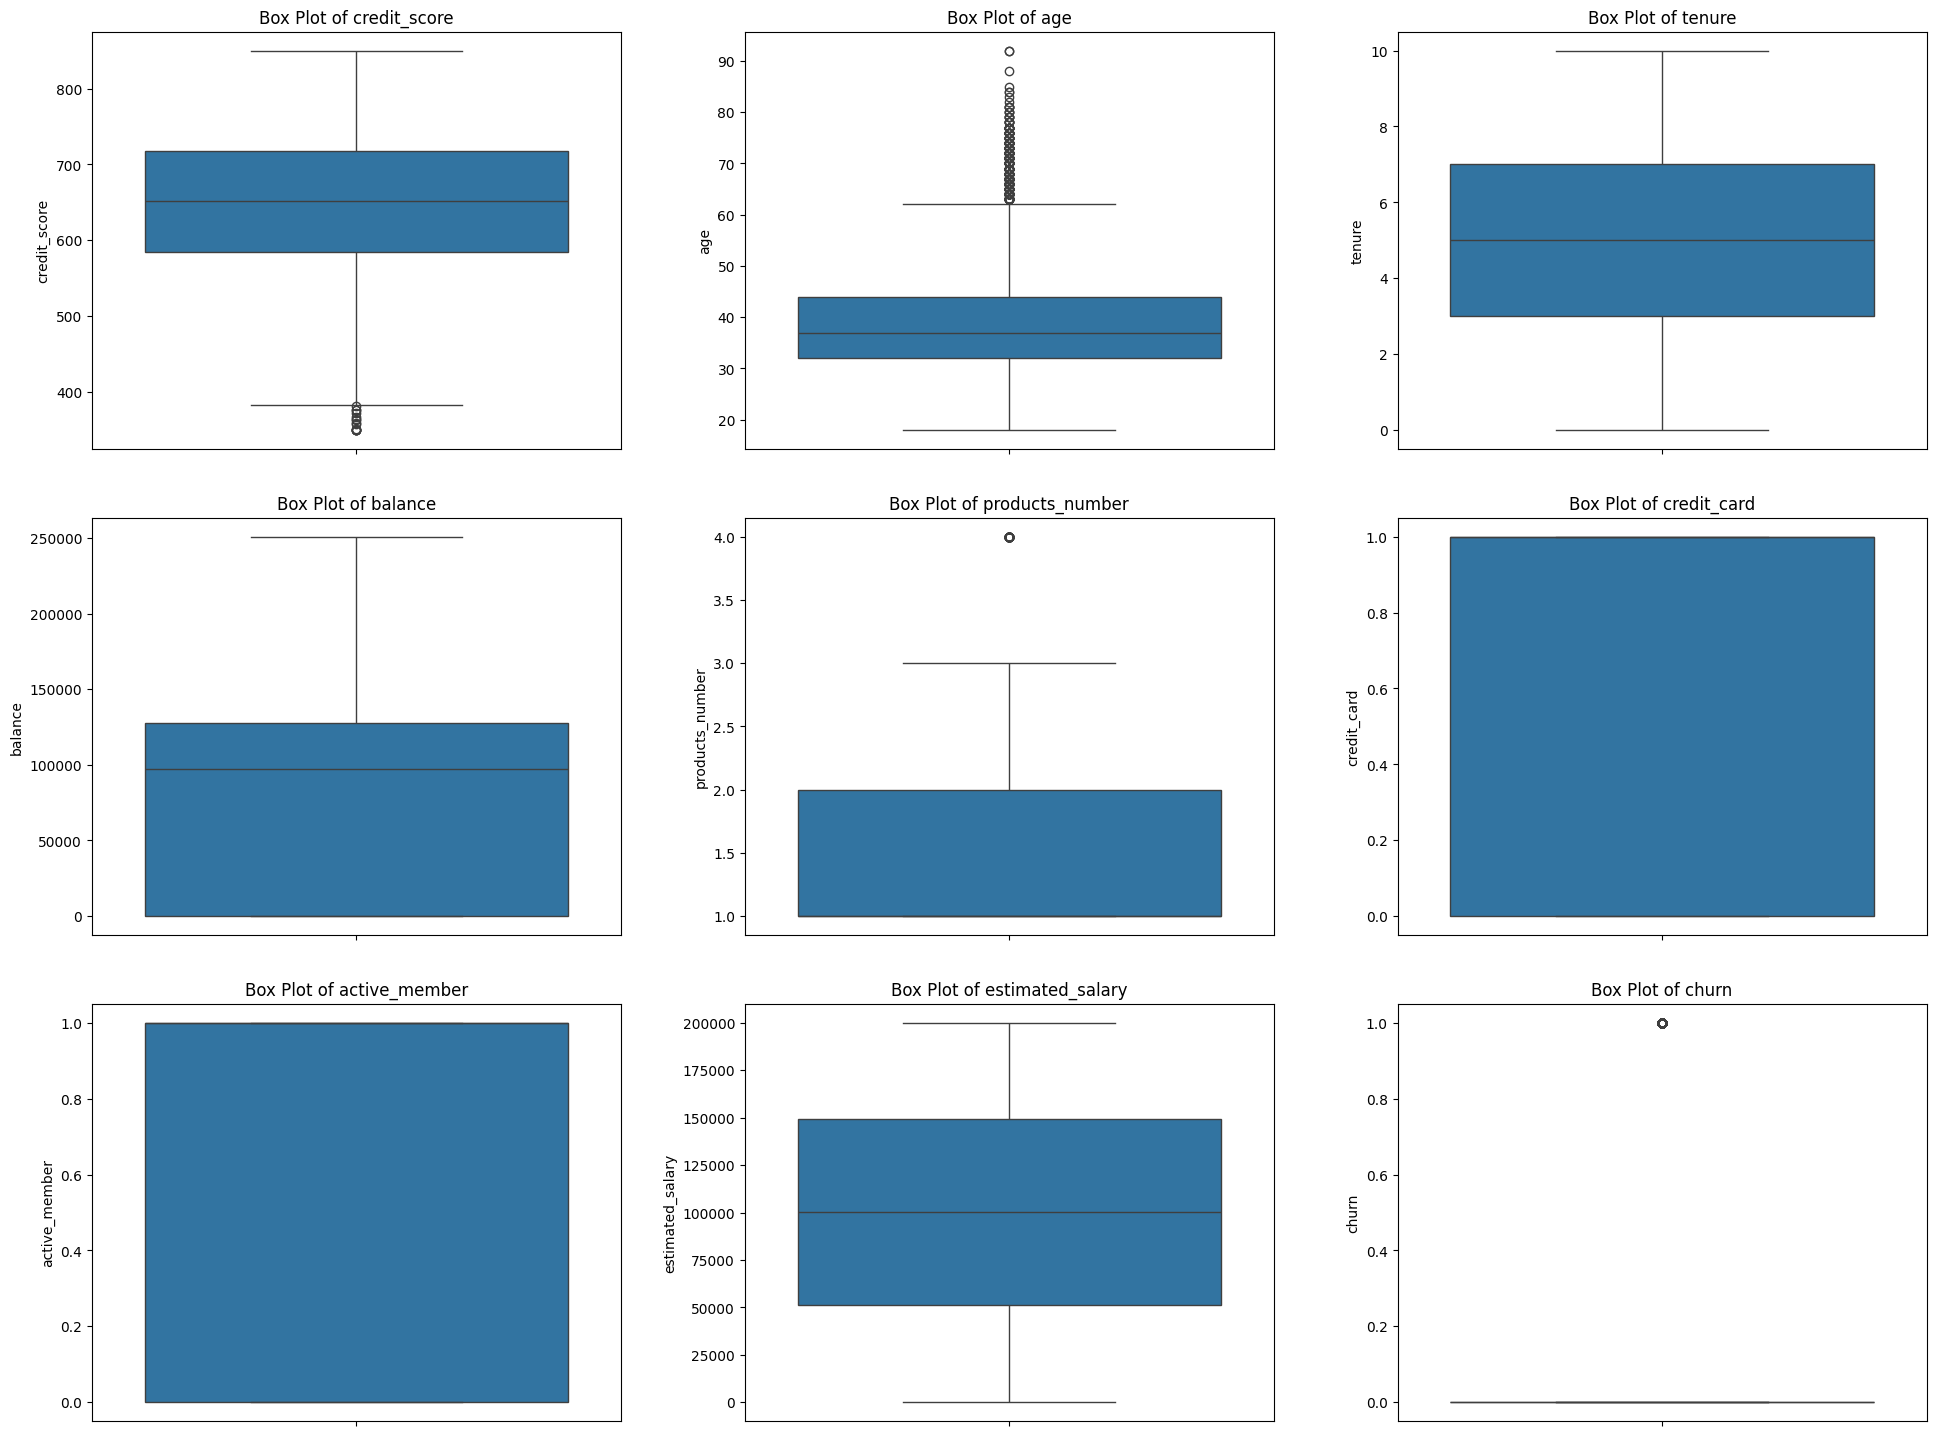

In [638]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Generate box plots for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_xlabel("")  # Remove x-label for cleaner look

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

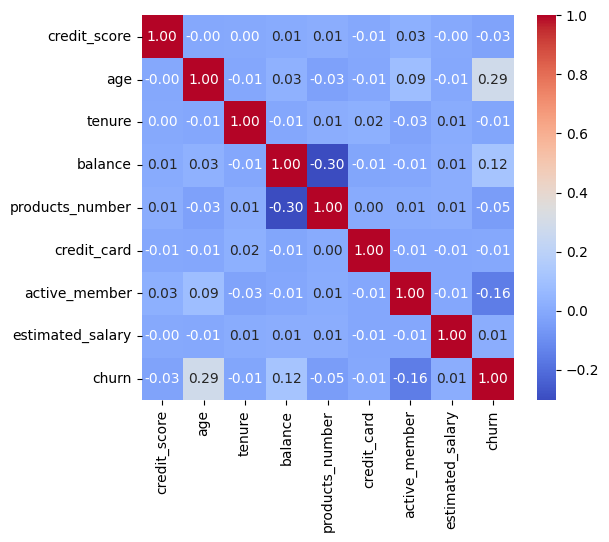

In [639]:
df_numeric = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = df_numeric.corr()

correlation_matrix['churn'].sort_values(ascending=False)

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title
plt.show()

C:\Users\clayton\AppData\Local\Temp\ipykernel_20528\3578586717.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis')
C:\Users\clayton\AppData\Local\Temp\ipykernel_20528\3578586717.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis')


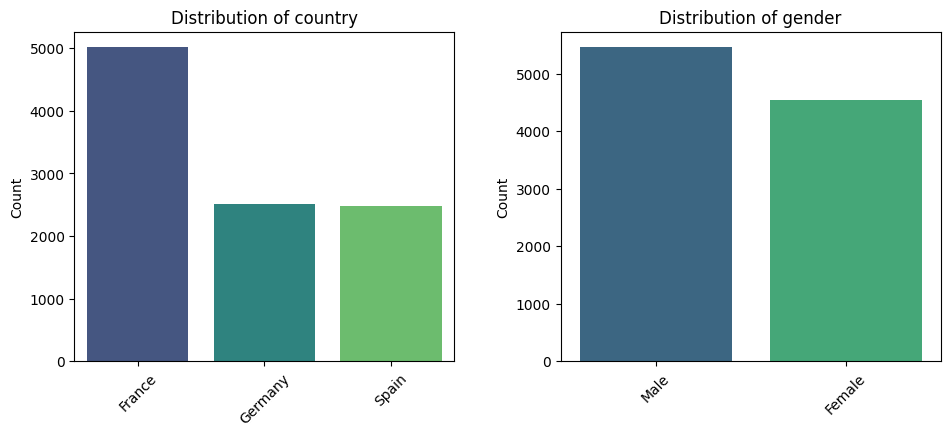

In [640]:
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Define grid size (3 plots per row)
num_cols = 3  
num_rows = math.ceil(len(categorical_cols) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel("")  # Remove x-axis label for clarity
    axes[i].set_ylabel("Count")  
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels if needed

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)  # Adjust spacing
plt.show()


C:\Users\clayton\AppData\Local\Temp\ipykernel_20528\298716273.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rates = df.groupby(col)['churn'].mean().sort_values()
C:\Users\clayton\AppData\Local\Temp\ipykernel_20528\298716273.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rates.index, y=churn_rates, palette='viridis')



Churn rates based on country: country
France     0.161548
Spain      0.166734
Germany    0.324432
Name: churn, dtype: float64


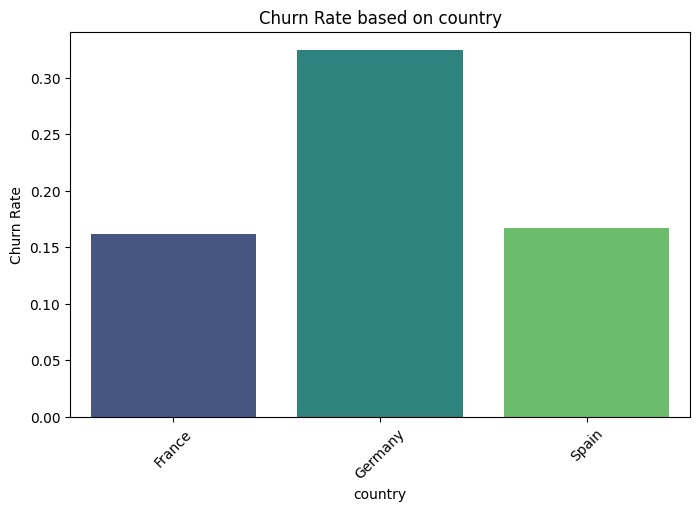


Churn rates based on gender: gender
Male      0.164559
Female    0.250715
Name: churn, dtype: float64


C:\Users\clayton\AppData\Local\Temp\ipykernel_20528\298716273.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rates = df.groupby(col)['churn'].mean().sort_values()
C:\Users\clayton\AppData\Local\Temp\ipykernel_20528\298716273.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rates.index, y=churn_rates, palette='viridis')


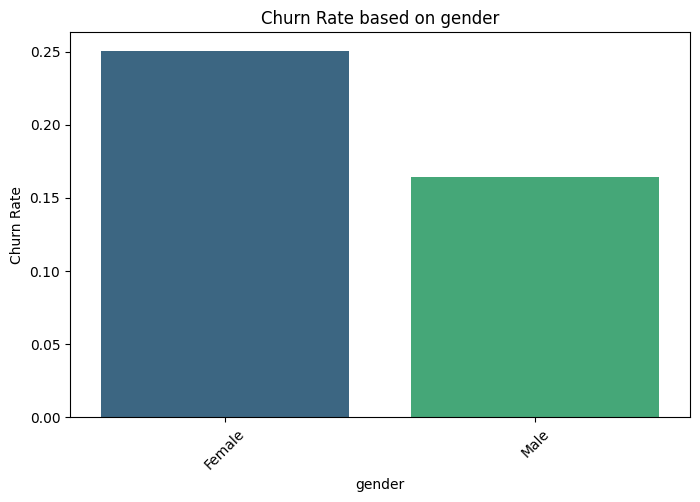

In [641]:
for col in categorical_cols:
    churn_rates = df.groupby(col)['churn'].mean().sort_values()
    print(f'\nChurn rates based on {col}:', churn_rates)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=churn_rates.index, y=churn_rates, palette='viridis')
    plt.title(f'Churn Rate based on {col}')
    plt.ylabel('Churn Rate')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.show()

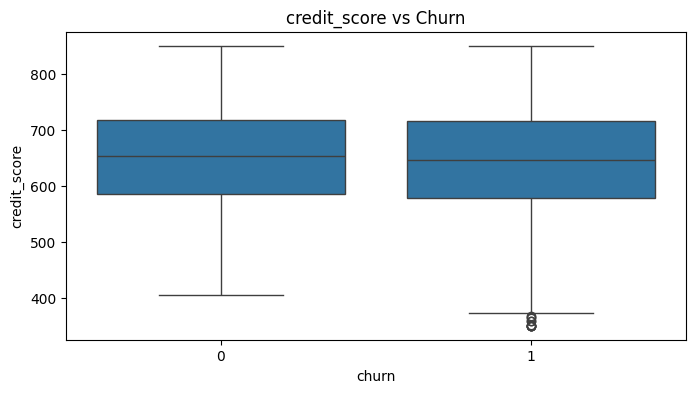

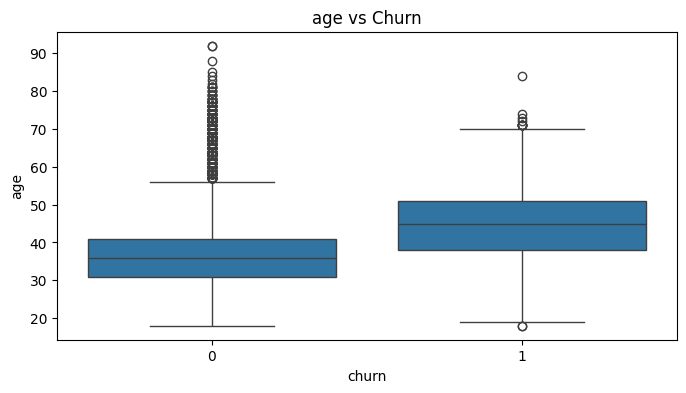

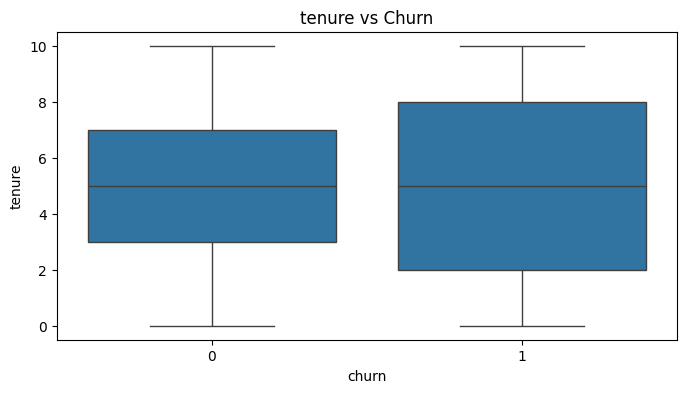

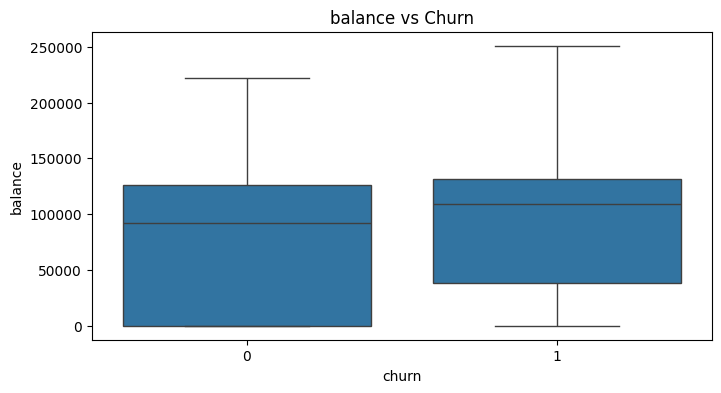

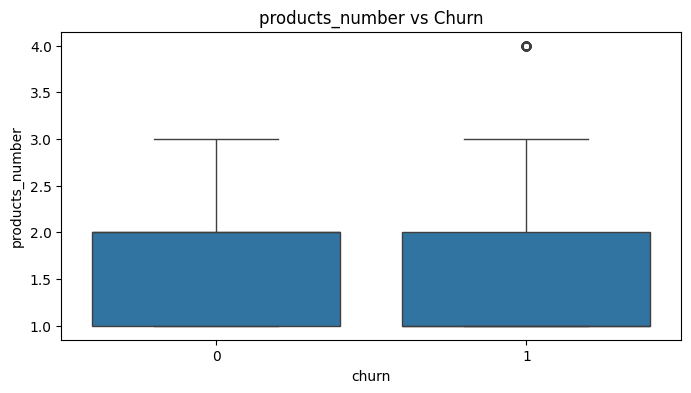

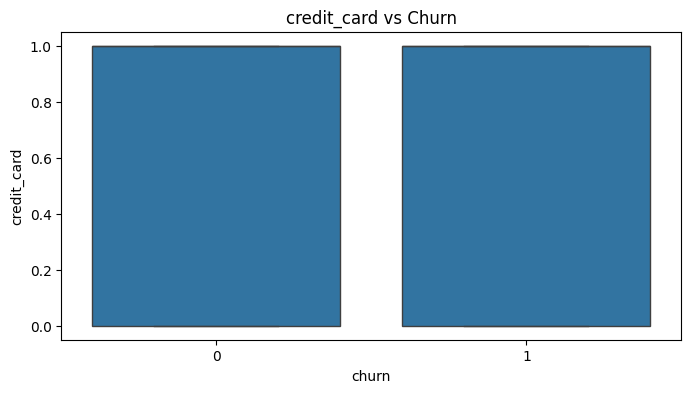

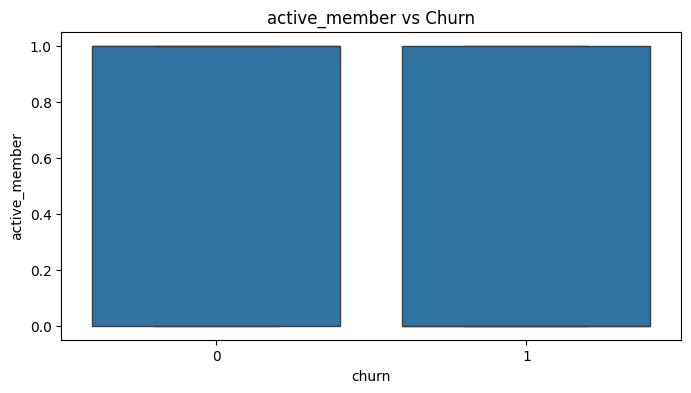

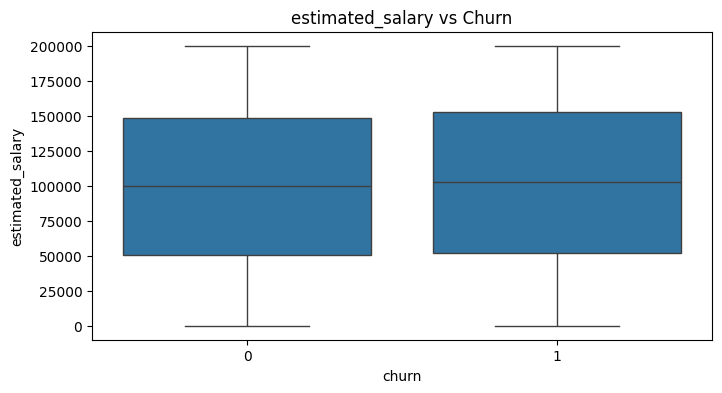

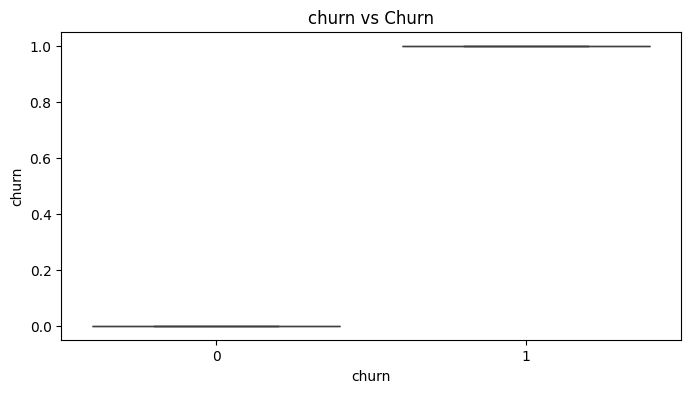

In [642]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df['churn'], y=df[col])
    plt.title(f'{col} vs Churn')
    plt.show()


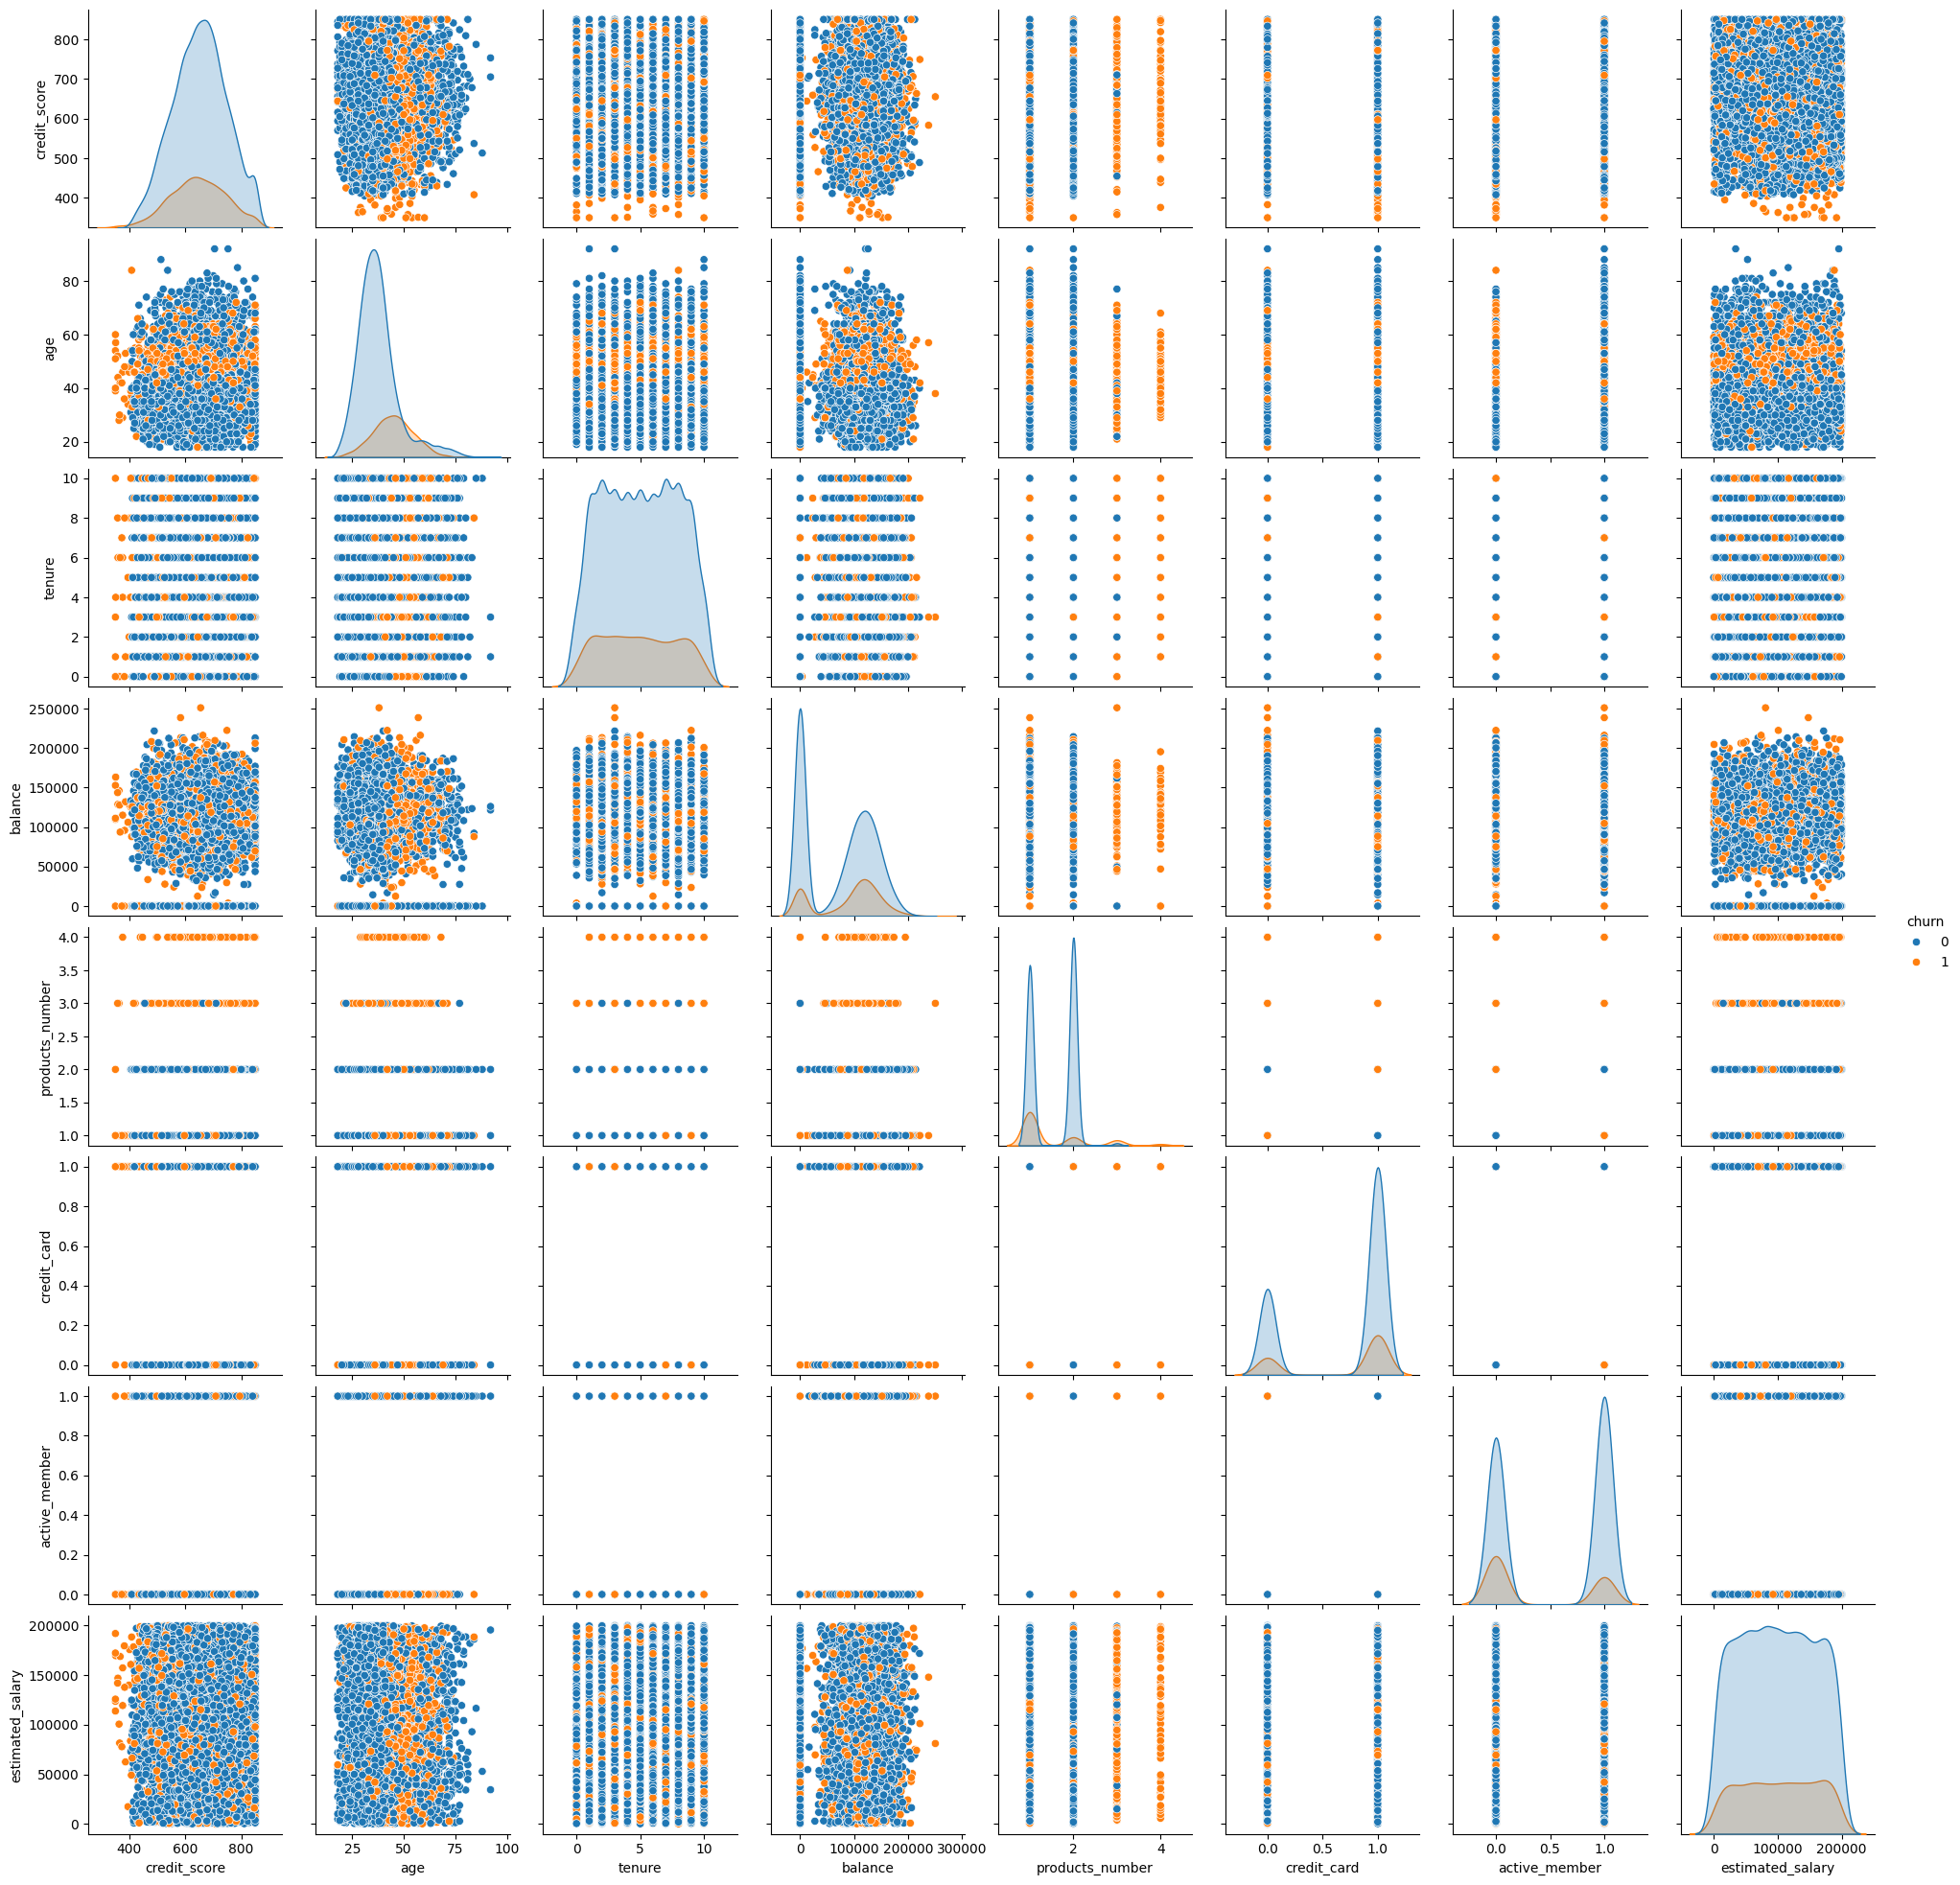

In [643]:
sns.pairplot(df, hue='churn', diag_kind='kde')
plt.show()

### 4. Data Preprocessing & Feature Engineering
- **Handle categorical variables**: One-hot encoding, label encoding.
- **Scale numerical features**: StandardScaler, MinMaxScaler.
- **Feature selection**: Recursive Feature Elimination (RFE), mutual information.
- **Create new features**: Aggregations, ratios, domain-specific transformations.
- **Split dataset**: Features then test
  - Classification/Regression: Train/Validation/Test (80/10/10 or 70/15/15)
  - Time Series: Rolling windows, expanding windows

In [644]:
'''from step 3 I want to bin age into 4 categories and make the target variable the same size as the other categories
for the categorical columns I want to encode them using one hot encoding because gender and country are nominal variables
I also don't have any columns with high collinearity so I won't drop any columns'''

# df['age_squared'] = df['age'] ** 2
# df['balance_squared'] = df['balance'] ** 2
# df['estimated_salary_squared'] = df['estimated_salary'] ** 2

target = 'churn'
# split the data into features and target
X = df.drop(target, axis=1)
y = df[target]

In [645]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [646]:
# # undersampling
# undersampler = RandomUnderSampler(random_state=42)
# X_train, y_train = undersampler.fit_resample(X_train, y_train)

# # smote
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [647]:
# numerical cols without the target variable
numerical_cols = numerical_cols.drop(target)  

# scaling the data
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### 5. Model Selection & Training
- **Baseline models**:
  - Classification: Logistic Regression, Decision Trees
  - Regression: Linear Regression, Ridge/Lasso Regression
  - Clustering: K-Means, DBSCAN
  - Time Series: ARIMA, Prophet
  - Anomaly Detection: Isolation Forest, One-Class SVM
- **Advanced models**:
  - Random Forest, XGBoost, Neural Networks
  - LSTMs for Time Series
  - Autoencoders for Anomaly Detection
- **Hyperparameter tuning**: GridSearchCV, RandomizedSearchCV, Bayesian Optimization
- **Cross-validation**: k-Fold for classification/regression, TimeSeriesSplit for time series

In [648]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [649]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',   # equivalent to loss='log_loss'
    learning_rate=0.1,             # same as learning_rate
    max_depth=3,                   # same as max_depth
    n_estimators=100,              # same as n_estimators
    subsample=1.0,                 # same as subsample
    colsample_bytree=1.0,          # equivalent to max_features=None (use all features)
    min_child_weight=1,            # roughly corresponds to min_samples_leaf=1
    random_state=5501,             # same as random_state
    verbosity=0,
    enable_categorical = True,     # equivalent to verbose=0
    scale_pos_weight=scale_pos_weight
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=5501, ...)

### 6. Model Evaluation & Interpretation
- **Classification**: Confusion matrix, precision-recall, AUC-ROC.
- **Regression**: RMSE, MAE, R².
- **Clustering**: Silhouette score, elbow method.
- **Time Series**: Forecast accuracy, residual plots.
- **Feature importance analysis**: SHAP values, permutation importance.

In [655]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

Accuracy: 0.8016
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      1991
           1       0.51      0.77      0.61       509

    accuracy                           0.80      2500
   macro avg       0.72      0.79      0.74      2500
weighted avg       0.85      0.80      0.82      2500

ROC AUC Score: 0.8766


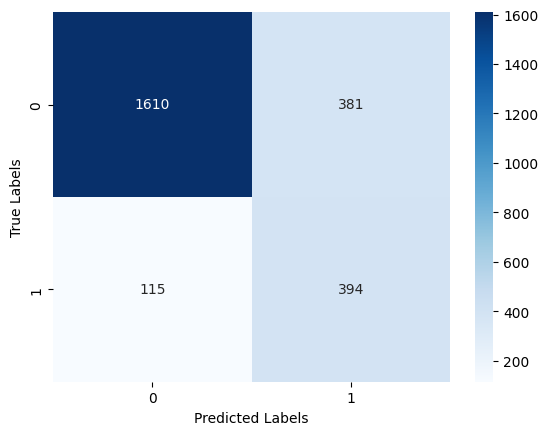

: 

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

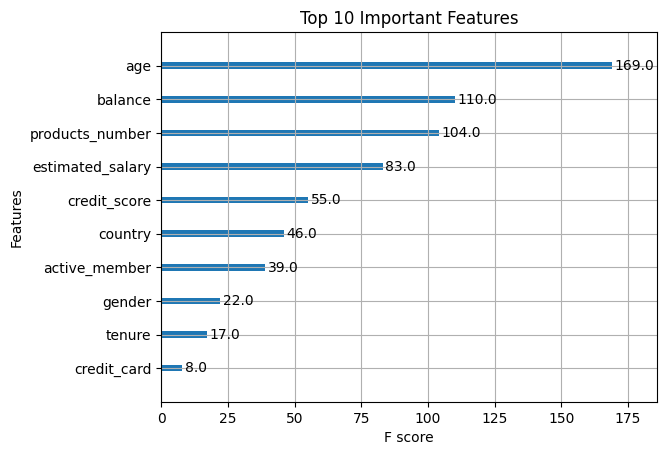

In [652]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()

### 7. Deployment & Monitoring
- **Save the model**: joblib, pickle, or ONNX.
- **Deploy as an API**: Flask, FastAPI, AWS Lambda.
- **Set up monitoring**:
  - Track model drift in data and performance.
  - Automate retraining when accuracy drops.

### 8. Iteration & Improvement
- **Analyze errors**: Look at misclassified cases or high-residual errors.
- **Feature engineering**: Add new features, remove redundant ones.
- **Try different models**: Ensemble learning, deep learning.
- **Data augmentation**: Synthetic data for small datasets.
- **Automate retraining**: CI/CD pipelines for model updates.